# 0.0 Imports

In [1]:
import tensorflow as tf
import json
import string
import pickle
import gensim
import re
from collections import Counter
import numpy as np
import seaborn as sns
from nltk.stem                          import WordNetLemmatizer
from nltk.corpus                        import stopwords, wordnet
from nltk.tokenize                      import word_tokenize
from wordcloud                          import WordCloud
from keras.models                       import load_model
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus                        import stopwords, wordnet
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection            import train_test_split
from sklearn.metrics                    import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

def evaluate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=0)
    recall = recall_score(y_true, y_pred, pos_label=0)
    f1 = f1_score(y_true, y_pred, pos_label=0)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

def lemmatize_word(word):
    lemma = lemmatizer.lemmatize(word, pos=wordnet.VERB)
    return lemmatizer.lemmatize(lemma, pos=wordnet.NOUN)

def process_text(text):
    text = text.lower()
    
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokemnization and lemmatization (without stopwords removal)
    words = text.split()
    lemmatized_words = [lemmatize_word(word) for word in words]
    text = ' '.join(lemmatized_words)
    
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    
    for word, i in vocab.items():
        if word in model.wv:
            weight_matrix[i] = model.wv[word]
    
    return weight_matrix

## 0.2 Loading Data

In [3]:
datastore = []
file_path = "../data/Sarcasm_Headlines_Dataset_v2.json"

with open(file_path, 'r') as f:
    for line in f:
        datastore.append(json.loads(line))

sentences = [item['headline'] for item in datastore]
labels = [item['is_sarcastic'] for item in datastore]

In [4]:
df_raw = pd.DataFrame(datastore)

In [5]:
df_raw.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


# 1.0 Data Description

In [6]:
df1 = df_raw.copy()

## 1.1 Data Dimension

In [7]:
print("Número de linhas: {}".format(df1.shape[0]))
print("Número de colunas: {}".format(df1.shape[1]))

Número de linhas: 28619
Número de colunas: 3


## 1.2 Data Types

In [8]:
df1.dtypes

is_sarcastic     int64
headline        object
article_link    object
dtype: object

## 1.3 Check NA

In [9]:
df1.isna().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

## 1.4 Most Used Words

In [10]:
#concatenate all texts in one variable
all_texts = ''.join(df1['headline'])

#Take words
words = all_texts.split()

#Count Words
word_counts = Counter(words)
df_words = pd.DataFrame(word_counts.items(), columns=['word','count'])

In [11]:
df_words.sort_values(by='count', ascending=False).head(10)

,word,count
31,to,8992
5,of,6230
62,in,4420
190,the,4294
93,for,3566
73,a,2818
16,on,2530
216,and,1949
45,with,1920
13,is,1582


### 1.4.1 Sarcastic Titles

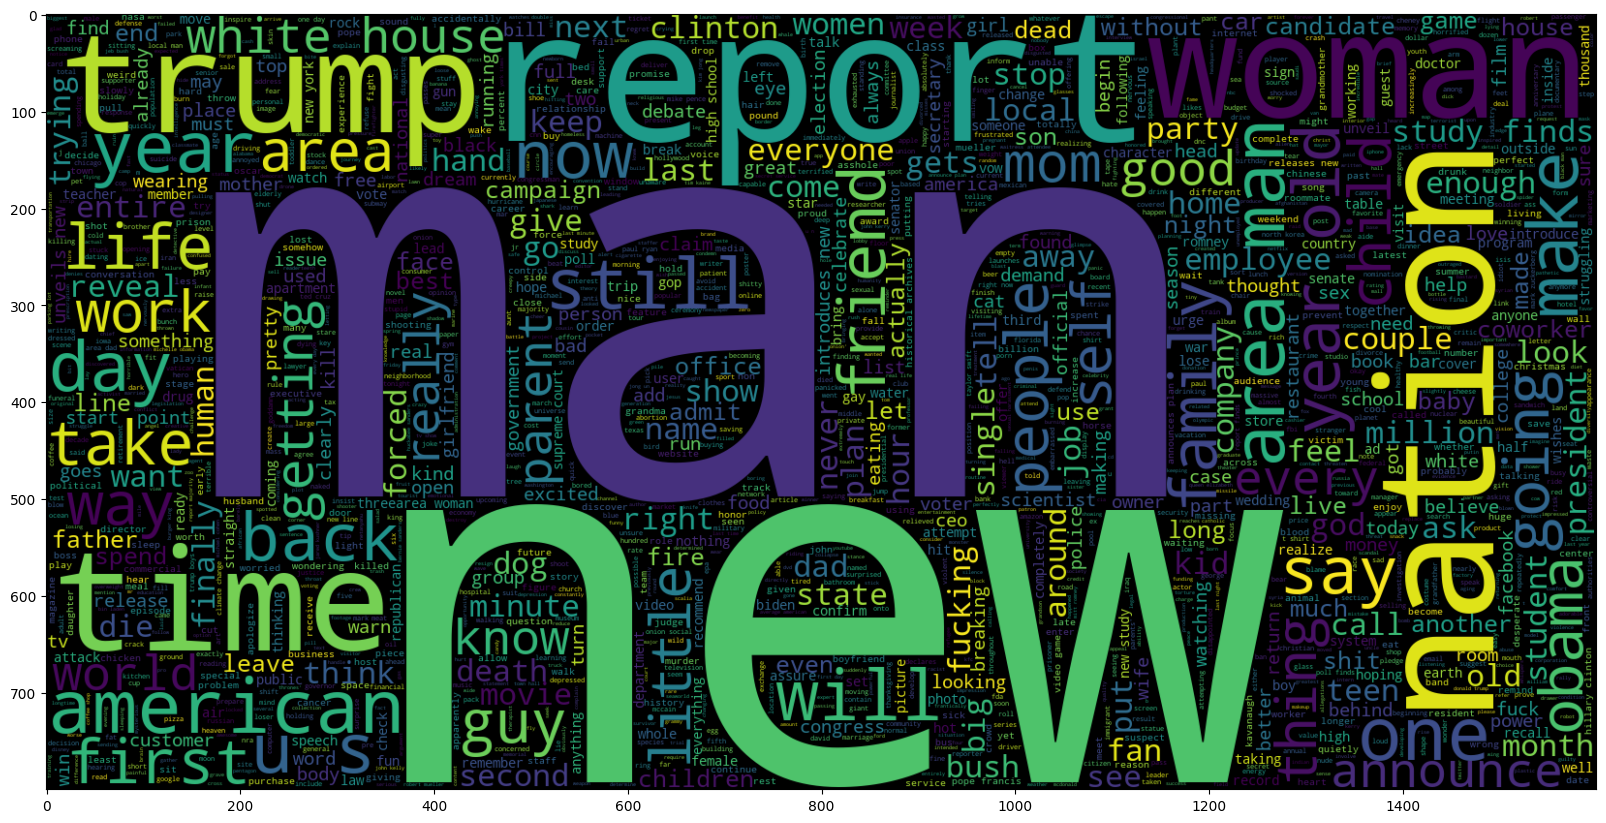

In [12]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df1[df1.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

### 1.4.2 Not Sarcastic Titles

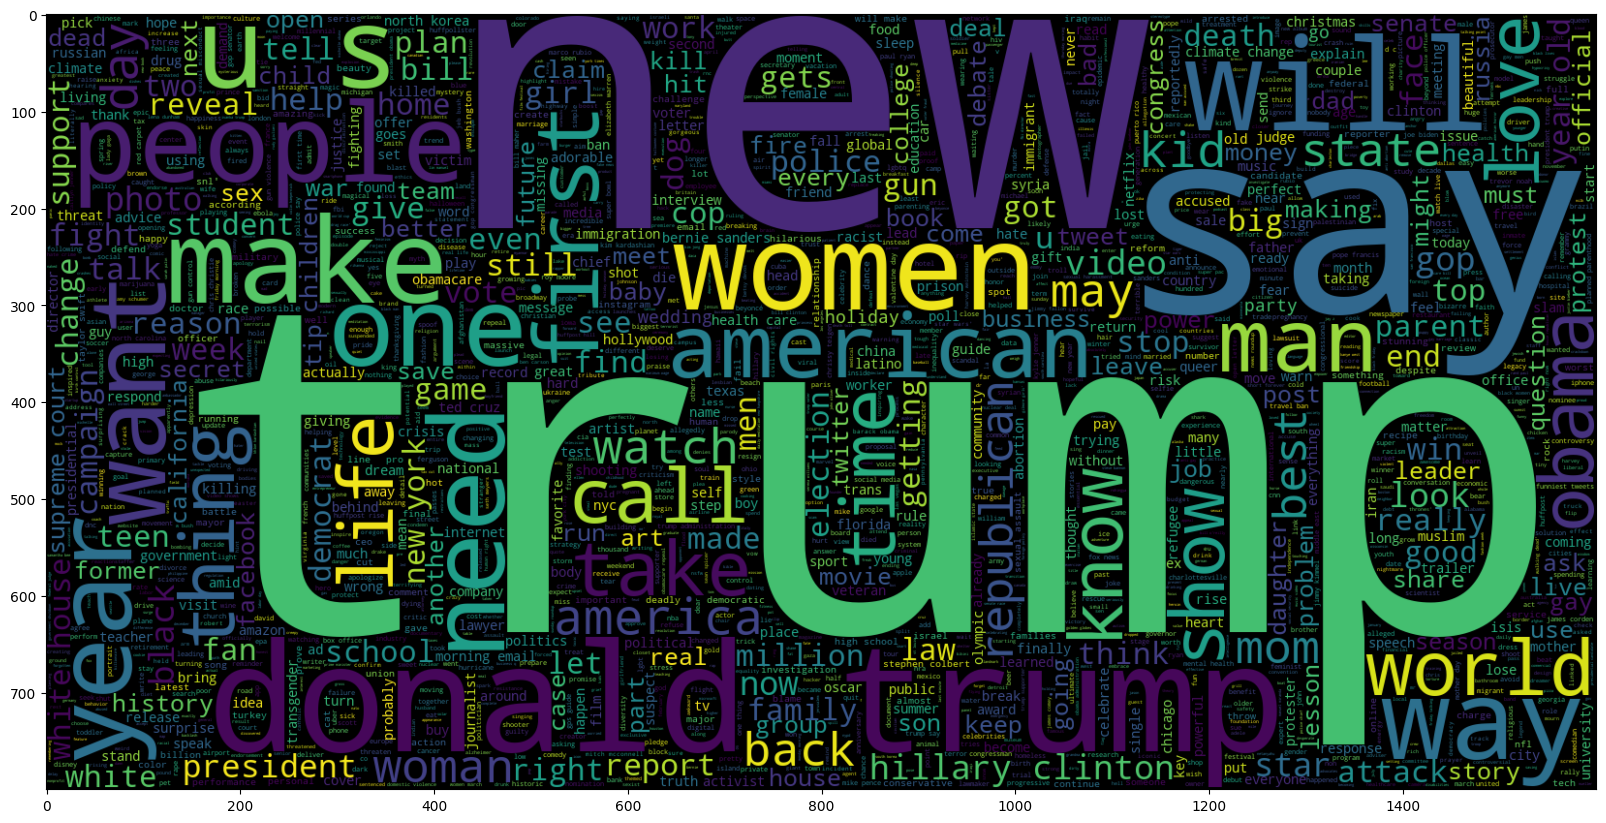

In [13]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df1[df1.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

# 2.0 Text Preprocessing

In [14]:
df2 = df1.copy()

In [15]:
df2['is_sarcastic'].value_counts(normalize=True)

0    0.523603
1    0.476397
Name: is_sarcastic, dtype: float64

## 2.1 Removing StopWords (?) and Start Lemmatization

- After many tests, the model's performance decreases a lot with stop words removal. So, I'll run the model without this process, only with lemmatization

In [16]:
nltk.download('wordnet')
#nltk.download('stopwords')

# Inicialize Lemmatizer
lemmatizer = WordNetLemmatizer()

df2['headline'] = df2['headline'].apply(process_text)

[nltk_data] Downloading package wordnet to /Users/luishmq/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
#concatenate all texts in one variable
all_texts_filtered = ''.join(df2['headline'])

#Take words
words_filtered = all_texts_filtered.split()

#Count Words
word_counts_filtered = Counter(words_filtered)
df_words_filtered = pd.DataFrame(word_counts_filtered.items(), columns=['word','count'])

### 2.1.1 Most used words

In [53]:
top_10_words = df_words_filtered.sort_values(by='count', ascending=False).head(10)
top_10_words

,word,count
31,to,9004
5,of,6238
185,the,4467
62,in,4436
13,be,4041
52,a,3708
91,for,3574
16,on,2545
75,and,1977
45,with,1922


Text(0.5, 1.0, 'Most Used Words')

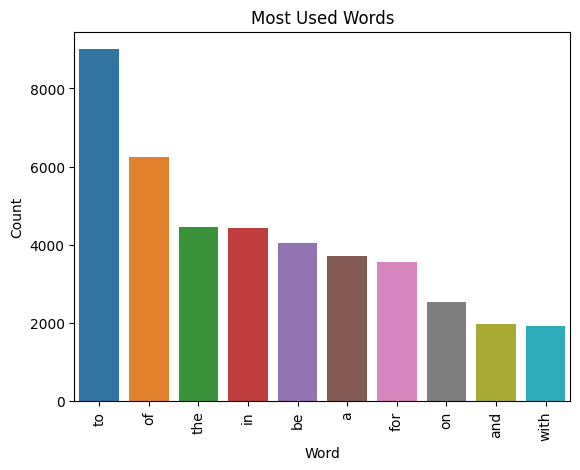

In [60]:
sns.barplot(data=top_10_words, x='word', y='count')
plt.xticks(rotation=90);
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Most Used Words')

# 3.0 Data Preparation

In [19]:
df3 = df2.copy()

df3 = df2[['headline', 'is_sarcastic']]

## 3.1 Split Train-Test

In [20]:
max_length = 512
vocab_size = 10000
oov_tok = "<OOV>"

train, validation = train_test_split(df3, test_size=0.3, random_state=42, stratify=df3['is_sarcastic'])

## 3.2 Tokenization

- Tokenization in Natural Language Processing (NLP) is the process of breaking down a text into smaller units, known as tokens. These tokens can be words, phrases, symbols, or other meaningful elements, depending on the level of granularity desired for analysis. Tokenization is a fundamental step in many NLP tasks, as it allows a computer to understand and process textual data.

In [21]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train['headline'])

training_sequences = tokenizer.texts_to_sequences(train['headline'])
training_padded = pad_sequences(training_sequences, maxlen=max_length)

testing_sequences = tokenizer.texts_to_sequences(validation['headline'])
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

word_index = tokenizer.word_index

In [22]:
pickle.dump(tokenizer, open('/Users/luishmq/Documents/repos/sarcastic_detection/src/model/tokenizer.pickle', 'wb'))

## 3.3 Changing to array

In [23]:
y_train = train['is_sarcastic'].copy()
y_validation = validation['is_sarcastic'].copy()

training_padded = np.array(training_padded)
y_train = np.array(y_train)
testing_padded = np.array(testing_padded)
y_validation = np.array(y_validation)

## 3.4 Word2Vec Embedding

- Word2Vec is a popular technique in Natural Language Processing (NLP) for generating word embeddings, which are vector representations of words in a continuous vector space. Word embeddings capture semantic relationships between words, enabling machines to understand the contextual meaning of words in a given text. The term "word2vec" is a combination of "word to vector," indicating the transformation of words into numerical vectors.
- Word2Vec embeddings have been widely used in NLP tasks such as sentiment analysis, document clustering, machine translation, and more, contributing to improved performance compared to traditional methods. They remain an influential and foundational technique in the field.

In [24]:
training_padded_w2v = [list(map(str, row)) for row in training_padded]

In [25]:
EMBEDDING_DIM = 200

w2v_model = gensim.models.Word2Vec(sentences = training_padded_w2v, vector_size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [26]:
len(w2v_model.wv.key_to_index)

10000

In [27]:
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [28]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

19307

# 4.0 Training Model

## 4.1 LSTM

- Bidirectional Long Short-Term Memory (BiLSTM) is an important concept in Natural Language Processing (NLP) that enhances the ability of neural networks to capture contextual information from both past and future elements in a sequence.

In [29]:
model = tf.keras.Sequential([
    # Emebdding layer
    tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length, weights=[embedding_vectors], trainable=True),

    # Bidirectional LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),

    # Pooling layer
    tf.keras.layers.GlobalMaxPooling1D(),

    # Dropout to avoid overfitting
    tf.keras.layers.Dropout(0.2),

    # Dense layer
    tf.keras.layers.Dense(24, activation='relu'),

    # Dropout to avoid overfitting
    tf.keras.layers.Dropout(0.2),

    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 200)          3861400   
                                                                 
 bidirectional (Bidirection  (None, 512, 128)          135680    
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dropout_1 (Dropout)         (None, 24)                0

In [31]:
num_epochs = 5
history = model.fit(training_padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_validation), verbose=2)

Epoch 1/5
627/627 - 189s - loss: 0.4433 - accuracy: 0.7921 - val_loss: 0.3666 - val_accuracy: 0.8410 - 189s/epoch - 302ms/step
Epoch 2/5
627/627 - 184s - loss: 0.2662 - accuracy: 0.8960 - val_loss: 0.3576 - val_accuracy: 0.8474 - 184s/epoch - 293ms/step
Epoch 3/5
627/627 - 181s - loss: 0.1543 - accuracy: 0.9425 - val_loss: 0.4418 - val_accuracy: 0.8399 - 181s/epoch - 288ms/step
Epoch 4/5
627/627 - 187s - loss: 0.0961 - accuracy: 0.9671 - val_loss: 0.5068 - val_accuracy: 0.8333 - 187s/epoch - 298ms/step
Epoch 5/5
627/627 - 190s - loss: 0.0564 - accuracy: 0.9818 - val_loss: 0.6494 - val_accuracy: 0.8346 - 190s/epoch - 303ms/step


In [32]:
model.save('/Users/luishmq/Documents/repos/sarcastic_detection/src/model/lstm_model.h5')

/Users/luishmq/.pyenv/versions/3.8.13/envs/sarcastic_detection/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
y_pred = model.predict(testing_padded)
y_pred_classes = (y_pred > 0.5).astype(int)
y_pred_classes

269/269 [==============================] - 19s 71ms/step


array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

# 5.0 Model Performance

## 5.1 Confusion Matrix

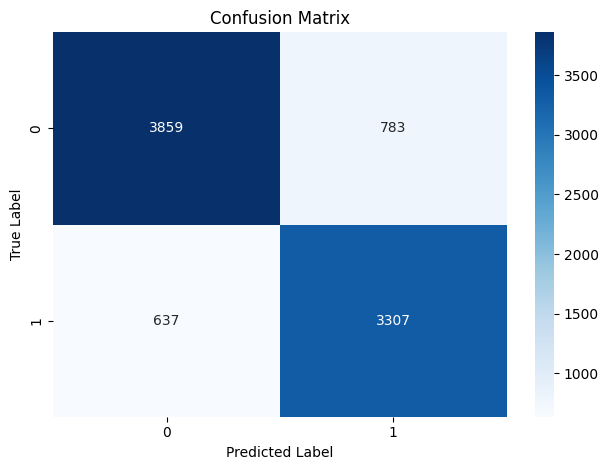

In [34]:
cmatrix = confusion_matrix(y_pred_classes, y_validation)

sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()

## 5.2 ROC Curve

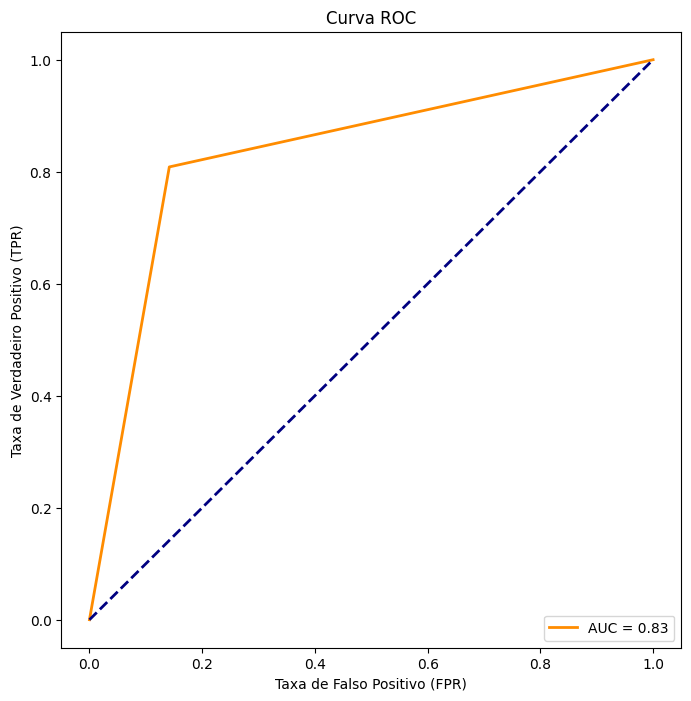

In [35]:
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_classes)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [36]:
evaluate_metrics(y_validation, y_pred_classes)

Accuracy: 0.8346
Precision: 0.8313
Recall: 0.8583
F1 Score: 0.8446


In [42]:
sentence = ['inclement weather prevents liar from getting to work']
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length)
print(model.predict(padded))

1/1 [==============================] - 0s 30ms/step
[[0.9979929]]


In [41]:
df1.iloc[3, 1]

'inclement weather prevents liar from getting to work'

In [39]:
df1.head(5)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
